In [109]:
!pip install wordcloud
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [209]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import glob, csv
import re
import string
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import time
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from string import punctuation
from string import digits
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from textblob import TextBlob 
from textblob import Word

In [210]:
interactions  = pd.read_csv('RAW_interactions.csv',index_col=0)# read csv into ratings_df dataframe
interactions.shape

(1132367, 4)

In [225]:
#interactions  = pd.read_csv('RAW_interactions.csv',index_col=0)# read csv into ratings_df dataframe
interactions=interactions.sample(10000)
interactions_df = pd.DataFrame(interactions)
interactions_df.head()

,recipe_id,date,rating,review,review_preprocessed
user_id,,,,,
1013852,293349,2009-07-13,5,"Delicious! I've made these several times now, ...",delicious time now great quick lunch snack per...
520853,188780,2017-10-31,5,Very simple to make and utterly delicious!,simple utterly delicious
2001218024,45354,2016-10-23,4,"Very good, lots of flavor. I added chicken sto...",good lot flavor chicken stock paste mixed sauc...
514937,125764,2009-08-05,5,This was the easiest salsa I have ever made an...,easy salsa simple ingredients love great salsa...
26313,37262,2003-07-26,5,YUMMMMMMM. I made this for a snack and let me ...,yummmmmmm snack let say love flavor reg mayo t...


In [226]:
eng_stopwords = set(stopwords.words("english"))
stop_words = stopwords.words('english')
eng_stop_words=list(ENGLISH_STOP_WORDS)
my_stop_words=['make','use','add','sugar','garlic','cup','half','eat',
               'come','butter','this','them','look','minute','recipe','oil','pan','rice','you','salt']
eng_stop_words.extend(my_stop_words)
stopwords_dict = Counter(stop_words)
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def stop_word_rem_and_lemmatization(text):
    lemm_text=[]
    #stop_words_cleaned_text=[word for word in text.split() if word not in stopwords_dict]
    
    
    for word,tag in pos_tag(text.lower().split()):
        lemm_text.append(lemmatizer.lemmatize(word, get_wordnet_pos(tag)))
    lemm_text=[word for word in lemm_text if word not in eng_stop_words]
    return " ".join(lemm_text)

def spell_correct(text):
    spell_correct_text=[TextBlob(word).correct() for word in text.split()]
    return ' '.join(spell_correct_text)

In [227]:
remove_digits = str.maketrans('', '', digits)

def preprocessData(text):
    #Text lemmatization and stop words removal
    sentence=stop_word_rem_and_lemmatization(text)
    #print(sentence)
    
    #sentence=spell_correct(sentence)
    
    #remove dots between abbreviations, U.S.A--> USA
    sentence=re.sub('\.(?!(\S[^. ])|\d)', '', sentence)
    
    #pad punctuations with spaces
    sentence = re.sub('([.,!;"?\'~#()&/{}_<>:|\-\*$])', r' \1 ', sentence)
         
    #remove all characters less than or equal to two characters
    sentence=re.sub(r'\b\w{1,2}\b', '', sentence)
    
    #remove all digits
    #sentence = ''.join([i for i in sentence if not i.isdigit()])
    sentence = sentence.translate(remove_digits)
    
    for ch in punctuation+'*()[]^@+=_/\$%-.,':
        sentence = sentence.replace(ch,'')
    
    #remove multiple whitespaces
    sentence= re.sub(' +', ' ', sentence)
    
    #sentence=re.sub('[^A-Za-z0-9\s]+', '', sentence)
            
    return sentence

In [229]:
interactions_df["review_preprocessed"] = interactions_df["review"].apply(lambda x: preprocessData(str(x)))
#interactions_df["review_preprocessed"] = interactions_df["review_preprocessed"].apply(lambda x: ' '.join(TextBlob(x).correct()))

In [230]:
interactions_df.head()

,recipe_id,date,rating,review,review_preprocessed
user_id,,,,,
1013852,293349,2009-07-13,5,"Delicious! I've made these several times now, ...",delicious time now great quick lunch snack per...
520853,188780,2017-10-31,5,Very simple to make and utterly delicious!,simple utterly delicious
2001218024,45354,2016-10-23,4,"Very good, lots of flavor. I added chicken sto...",good lot flavor chicken stock paste mixed sauc...
514937,125764,2009-08-05,5,This was the easiest salsa I have ever made an...,easy salsa simple ingredients love great salsa...
26313,37262,2003-07-26,5,YUMMMMMMM. I made this for a snack and let me ...,yummmmmmm snack let say love flavor reg mayo t...


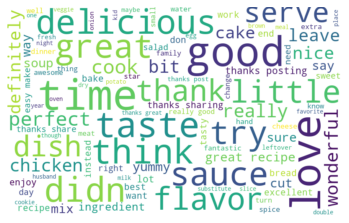

In [196]:
txt = ' '.join(review for review in interactions_df.review_preprocessed)

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

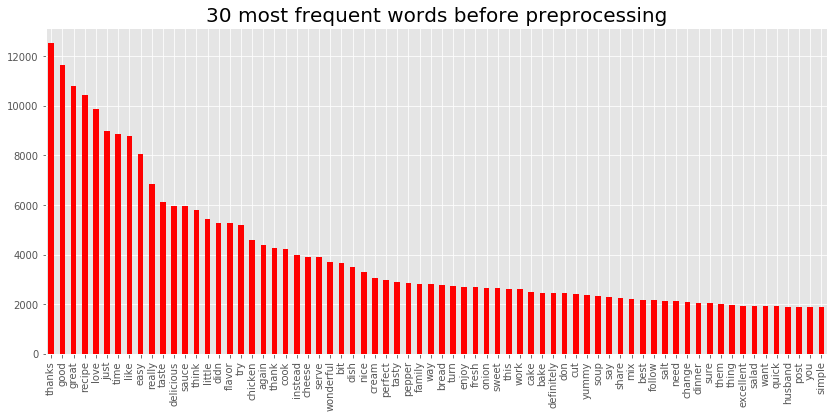

In [197]:
txt = pd.Series(' '.join(review for review in interactions_df.review_preprocessed).split())

plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=txt.value_counts()[:70]
freq.plot(kind="bar", color = "red")
plt.title("30 most frequent words before preprocessing",size=20)
plt.show()

In [198]:
rating_not_zero=interactions_df["rating"]!=0
interactions_data=interactions_df[rating_not_zero]
interactions_data.shape

(37928, 5)

In [199]:
rating_zero=interactions_df["rating"]==0
interactions_test=interactions_df[rating_zero]
interactions_test.shape

(2072, 5)

In [200]:


# data split 
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(interactions_data['review_preprocessed'], interactions_data['rating'], test_size = 0.3)



In [201]:
# Convert text to numbers using (BOW)! 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b',ngram_range=(1,3),max_features=10000)

# let's convert 
xtrain_bow = vectorizer.fit_transform(xtrain).toarray()
xtest_bow = vectorizer.transform(xtest).toarray()

In [202]:


# Convert text to numbers using (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer  

tf_vectorizer = TfidfVectorizer(norm = 'l2',min_df = 0, use_idf = True, smooth_idf = False, sublinear_tf = True,
                             ngram_range=(1,3), max_features = 15000,token_pattern=r'\b\w+\b',analyzer='word')

# let's convert 
xtrain_tf = tf_vectorizer.fit_transform(xtrain).toarray()
xtest_tf = tf_vectorizer.transform(xtest).toarray()



In [203]:
from sklearn.naive_bayes import GaussianNB

# USING BOW 
clf_bow = GaussianNB().fit(xtrain_bow, ytrain)  # fitting 
prediction_bow = clf_bow.predict(xtest_bow)  # predictions

# USINGN TFIDF 
clf_tf = GaussianNB().fit(xtrain_tf, ytrain)
prediction_tf = clf_tf.predict(xtest_tf)

In [204]:


# let's check our model! 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

def metrics(prediction, actual): 
    print('Confusion_matrix \n', confusion_matrix(actual, prediction))
    print('\nAccuracy:', accuracy_score(actual, prediction))
    print('\nclassification_report\n')
    print(classification_report(actual, prediction))
    
    
metrics(prediction_bow, ytest)



Confusion_matrix 
 [[  14   11   19   66   31]
 [  10   16   20   80   27]
 [  13   24   73  263   82]
 [  33   41  168 1376  386]
 [ 147  122  463 5219 2675]]

Accuracy: 0.3650584409877845

classification_report

              precision    recall  f1-score   support

           1       0.06      0.10      0.08       141
           2       0.07      0.10      0.09       153
           3       0.10      0.16      0.12       455
           4       0.20      0.69      0.31      2004
           5       0.84      0.31      0.45      8626

    accuracy                           0.37     11379
   macro avg       0.25      0.27      0.21     11379
weighted avg       0.67      0.37      0.40     11379



In [205]:


metrics(prediction_tf, ytest)



Confusion_matrix 
 [[  12   11   16   56   46]
 [  10   10   19   72   42]
 [  10   19   55  225  146]
 [  26   25  108 1148  697]
 [ 100  102  304 4099 4021]]

Accuracy: 0.46102469461288337

classification_report

              precision    recall  f1-score   support

           1       0.08      0.09      0.08       141
           2       0.06      0.07      0.06       153
           3       0.11      0.12      0.11       455
           4       0.20      0.57      0.30      2004
           5       0.81      0.47      0.59      8626

    accuracy                           0.46     11379
   macro avg       0.25      0.26      0.23     11379
weighted avg       0.66      0.46      0.51     11379



In [206]:

# USING BOW 
lr = LogisticRegression(C=1000,max_iter=100, penalty='l2', solver='newton-cg')
clf_bow = lr.fit(xtrain_bow, ytrain)  # fitting 
prediction_bow = lr.predict(xtest_bow)  # predictions

# USINGN TFIDF 
clf_tf = lr.fit(xtrain_tf, ytrain)
prediction_tf = lr.predict(xtest_tf)

In [207]:
print(classification_report(ytest, prediction_tf))

              precision    recall  f1-score   support

           1       0.44      0.21      0.28       141
           2       0.25      0.16      0.19       153
           3       0.29      0.23      0.25       455
           4       0.31      0.37      0.34      2004
           5       0.84      0.83      0.83      8626

    accuracy                           0.71     11379
   macro avg       0.43      0.36      0.38     11379
weighted avg       0.71      0.71      0.71     11379

